# AI 전문가 교육과정 실습 2 - part 3

***
### NLP응용: 토픽 추출
Applied Natrual Language Processing: Topic Modeling

강사: 차미영 교수 (카이스트 전산학부)    
조교: 신민기, 정현규 (카이스트 전산학부)

# Contextualized Topic Model (sentence-BERT & VAE)

In [ ]:
!pip install sentence_transformers

In [ ]:
import numpy as np
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt

## Define dataset

In [ ]:
class CTMDataset(Dataset):
    def __init__(self, text_list, vectorizer, encoder):
        # Normalize text
        self.plain_text = [text for text in text_list if len(text) > 0]

        # Get Bag of Words document
        self.vectorizer = vectorizer
        vectorized_input = self.vectorizer.fit_transform(self.plain_text)
        vectorized_input = vectorized_input.toarray()                     # scipy sparse matrix to numpy array
        
        # Exclude empty documents from data
        empty_doc_num = np.where(vectorized_input.sum(axis=1) == 0)[0]
        vectorized_input = np.delete(vectorized_input, empty_doc_num, axis=0)
        self.filtered_text = [text for i, text in enumerate(self.plain_text) if i not in empty_doc_num]
        
        # Get word distribution from BoW
        vectorized_input = vectorized_input / vectorized_input.sum(axis=1, keepdims=True)
        assert abs(vectorized_input.sum() - vectorized_input.shape[0]) < 0.01
        self.vectorized_label = torch.tensor(vectorized_input, dtype=torch.float)

        self.encoder = encoder

    def __len__(self):
        return len(self.filtered_text)
    
    def __getitem__(self, idx):
        embedded_input = self.encoder(self.filtered_text[idx]).cpu()
        item = embedded_input, self.vectorized_label[idx]
        return item

In [ ]:
newsgroups_data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes')).data
use_cuda = True
N_topic = 20
newsgroups_data_train = newsgroups_data[:(len(newsgroups_data)*8)//10]
newsgroups_data_test = newsgroups_data[(len(newsgroups_data)*8)//10:]

In [ ]:
model_name = 'paraphrase-distilroberta-base-v1'
sbert = SentenceTransformer(model_name)
encoder = lambda x: sbert.encode(x,
                      batch_size=1, show_progress_bar=False, convert_to_tensor=True)
dataset = CTMDataset(newsgroups_data_train, CountVectorizer(stop_words='english', max_features=2000), encoder)

## Contextualized Topic Model (w SentenceBert)

In [ ]:
class SBertTopicEncoder(nn.Module):
    def __init__(self, N_topic, N_word, bert_size, name, hidden_sizes=(100, 100), dropout=0.2):
        super(SBertTopicEncoder, self).__init__()
        self.N_topic = N_topic

        self.input_layer = nn.Linear(N_word+N_word, hidden_sizes[0])
        self.adapt_bert = nn.Linear(bert_size, N_word)

        self.activation = nn.Softplus()
        self.dropout_enc = nn.Dropout(p=dropout)

        self.fc = nn.Sequential(OrderedDict([
            ('l_{}'.format(i), nn.Sequential(nn.Linear(h_in, h_out), self.activation))
            for i, (h_in, h_out) in enumerate(zip(hidden_sizes[:-1], hidden_sizes[1:]))]))
        
        self.f_mu = nn.Linear(hidden_sizes[-1], N_topic)
        self.f_mu_batchnorm = nn.BatchNorm1d(N_topic, affine=False)

        self.f_sigma = nn.Linear(hidden_sizes[-1], N_topic)
        self.f_sigma_batchnorm = nn.BatchNorm1d(N_topic, affine=False)

    def forward(self, bert_embedding, bow):
        x_bert = self.adapt_bert(bert_embedding)
        x = torch.cat((bow, x_bert), 1)
        x = self.input_layer(x)

        x = self.activation(x)
        x = self.fc(x)
        x = self.dropout_enc(x)

        mu = self.f_mu_batchnorm(self.f_mu(x))
        log_sigma = self.f_sigma_batchnorm(self.f_sigma(x))
        
        return mu, log_sigma

    
class LDADecoder(nn.Module):
    def __init__(self, N_topic, N_word, dropout=0.2, learn_priors=True):
        super(LDADecoder, self).__init__()
        self.N_topic = N_topic
        self.N_word = N_word
        self.learn_priors = learn_priors

        # init prior parameters
        # \mu_1k = log \alpha_k + 1/K \sum_i log \alpha_i;
        # \alpha = 1 \forall \alpha
        topic_prior_mean = 0.0
        self.prior_mean = torch.tensor(
            [topic_prior_mean] * N_topic)
        if torch.cuda.is_available():
            self.prior_mean = self.prior_mean.cuda()
        if self.learn_priors:
            self.prior_mean = nn.Parameter(self.prior_mean)

        # \Sigma_1kk = 1 / \alpha_k (1 - 2/K) + 1/K^2 \sum_i 1 / \alpha_k;
        # \alpha = 1 \forall \alpha
        topic_prior_variance = 1. - (1. / self.N_topic)
        self.prior_variance = torch.tensor(
            [topic_prior_variance] * N_topic)
        if torch.cuda.is_available():
            self.prior_variance = self.prior_variance.cuda()
        if self.learn_priors:
            self.prior_variance = nn.Parameter(self.prior_variance)
            
        self.beta = torch.Tensor(N_topic, N_word)
        self.beta = nn.Parameter(self.beta)
        nn.init.xavier_uniform_(self.beta)
        #self.fc = nn.Linear(N_topic, N_word, bias=False)

        self.beta_batchnorm = nn.BatchNorm1d(N_word, affine=False)

        self.dropout = dropout
        self.drop_theta = nn.Dropout(p=self.dropout)

    @staticmethod
    def reparameterize(mu, logvar):
        """Reparameterize the theta distribution."""
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, mu, log_sigma):
        latent_topic = F.softmax(self.reparameterize(mu, log_sigma), dim=1)
        latent_topic = self.drop_theta(latent_topic)

        #prodLDA
        word_dist = F.softmax(self.beta_batchnorm(torch.matmul(latent_topic, self.beta)), dim=1)

        return word_dist
    


class CombinedTM(nn.Module):
    def __init__(self, N_topic, N_word, name=model_name, pooling='cls'):
        super(CombinedTM, self).__init__()
        self.N_topic = N_topic
        self.name = name

        self.encoder = SBertTopicEncoder(N_topic, N_word, 768, name, hidden_sizes=(100, 100), dropout=0.2)
        self.decoder = LDADecoder(N_topic, N_word)

    def forward(self, input_dict, bow):
        mu, log_sigma = self.encoder(input_dict, bow) # (B, N_topic) 
        reconstruction = self.decoder(mu, log_sigma) # (B, N_word)
        return reconstruction, (mu, log_sigma)

In [ ]:
model = CombinedTM(N_topic, 2000, name=model_name)

## Training

In [ ]:
num_epoch = 10
print_interval = 10
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, pin_memory=True)
model.train()
model.cuda()
optim = torch.optim.Adam(model.parameters(), lr=2e-3)

for epoch in range(num_epoch):
    print('epoch', epoch)
    count = 0
    loss_sum = 0.0
    
    for batch in dataloader:
        optim.zero_grad()
        input1 = batch[0].cuda()
        label1 = batch[1].cuda()
        
        output1, topic1 = model(input1, label1)
        mu, log_sigma = topic1
        sigma = torch.exp(log_sigma)
        
        # reconstruction loss
        reconstruction_loss = -torch.sum(torch.log(output1 + 1E-10) * label1)
        # KL loss
        # var division term
        var_division = torch.sum(sigma / model.decoder.prior_variance, dim=1)
        # diff means term
        diff_means = model.decoder.prior_mean - mu
        diff_term = torch.sum(
            (diff_means * diff_means) / model.decoder.prior_variance, dim=1)
        # logvar det division term
        logvar_det_division = \
            model.decoder.prior_variance.log().sum() - log_sigma.sum(dim=1)
        # combine terms
        KL = 0.5 * (
            var_division + diff_term - N_topic + logvar_det_division)
        
        loss = reconstruction_loss + KL
        loss = loss.sum()
        
        loss_sum += loss.item()
        count += 1
        
        loss.backward()
        optim.step()
        if count % print_interval == 0:
            print('{:5d} avg loss:{:.10f}'.format(count, loss_sum / print_interval, 
                loss_sum / print_interval))
            loss_sum = 0.0

epoch 0
   10 avg loss:33932.2296875000
   20 avg loss:33718.5949218750
   30 avg loss:33575.7957031250
   40 avg loss:33400.2242187500
   50 avg loss:33192.3832031250
   60 avg loss:33068.7539062500
   70 avg loss:32927.3882812500
   80 avg loss:32714.8900390625
   90 avg loss:32546.1046875000
  100 avg loss:32392.3341796875
  110 avg loss:32351.9585937500
  120 avg loss:32166.5990234375
  130 avg loss:32054.6402343750
epoch 1
   10 avg loss:31883.6822265625
   20 avg loss:31765.0384765625
   30 avg loss:31759.7416015625
   40 avg loss:31707.8535156250
   50 avg loss:31548.9792968750
   60 avg loss:31560.2943359375
   70 avg loss:31455.3601562500
   80 avg loss:31510.0300781250
   90 avg loss:31460.8935546875
  100 avg loss:31421.3125000000
  110 avg loss:31396.4898437500
  120 avg loss:31310.2312500000
  130 avg loss:31321.8267578125
epoch 2
   10 avg loss:31228.4291015625
   20 avg loss:31170.1455078125
   30 avg loss:31138.2501953125
   40 avg loss:31166.5812500000
   50 avg loss:3

## Evaluation

In [ ]:
model.eval()
dictionary = {idx: token for token, idx in dataset.vectorizer.vocabulary_.items()}
decoder_weight = model.decoder.beta.detach().cpu()

In [ ]:
top_topic_keywords = []
for i in range(N_topic):
    topic_vec = decoder_weight[i]
    topic_vec = sorted( list(zip(range(topic_vec.shape[0]),topic_vec)), key = lambda k: -k[1] )
    topic_vec = [ (dictionary[i], w.item()) for i,w in topic_vec][:10]
    word_vec = [word[0] for word in topic_vec]
    top_topic_keywords.append(word_vec)
    print(' '.join(word_vec))

jews war state israel israeli rights country killed islamic arab
using window set problem use windows running file run dos
problem drive speed switch power turn work running cpu bad
edu com university article space address deleted nasa internet stuff
ax david alt hey said read max bob post writes
card drive cards video apple problem machine mhz slot scsi
price 00 best sale new condition sell 10 offer shipping
card printer does looking video driver need price mac pc
thanks know does mail address advance email posting let send
pitt surrender soon pain banks msg gordon blood body food
god true truth religion believe jesus christians church people don
car bike new model engine cars buy price like dealer
just think don agree god say did love said true
key chip phone public encryption clipper strong government keys secret
year 12 30 april 11 baseball period games gm st
game team win runs games play stats year toronto won
space orbit water bike road large moon thing riding look
thanks hi test

In [ ]:
def testset_eval(testset, vectorizer, topicmodel, encoder):
    test_dataset = CTMDataset(newsgroups_data_train, vectorizer, encoder)
    test_dataloader = DataLoader(test_dataset, batch_size=64)
    topicmodel.eval()
    device = next(topicmodel.parameters()).device
    topics = None
    log_sigmas = None
    log_likelihood = None
    with torch.no_grad():
        for test_batch in test_dataloader:
            assert test_batch[0].shape[0] == test_batch[1].shape[0]
            input_test = test_batch[0].to(device)
            label = test_batch[1].to(device)
            test_output, test_topic = topicmodel(input_test, label)
            test_mu, test_log_sigma = test_topic
            result = torch.sum(torch.log(test_output) * label, dim=-1)
            if log_likelihood == None:
                log_likelihood = result
                topics = test_mu
                log_sigmas = test_log_sigma
            else:
                log_likelihood = torch.cat((log_likelihood, result), dim=0)
                topics = torch.cat((topics, test_mu), dim=0)
                log_sigmas = torch.cat((log_sigmas, test_log_sigma), dim=0)
    return log_likelihood.detach().cpu(), topics.detach().cpu(), log_sigmas.detach().cpu()

In [ ]:
tmp = testset_eval(newsgroups_data_test, dataset.vectorizer, model, encoder)

In [ ]:
log_likelihood, topics_test, log_sigma_test = tmp

In [ ]:
list_log_likelihood = list(log_likelihood.numpy())

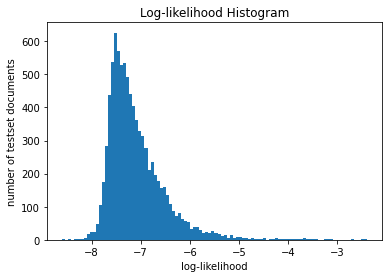

In [ ]:
plt.hist(list_log_likelihood, bins=100)
plt.title('Log-likelihood Histogram')
plt.ylabel('number of testset documents')
plt.xlabel('log-likelihood')
plt.show()

In [ ]:
torch.mean(log_likelihood).item()

-7.096999168395996

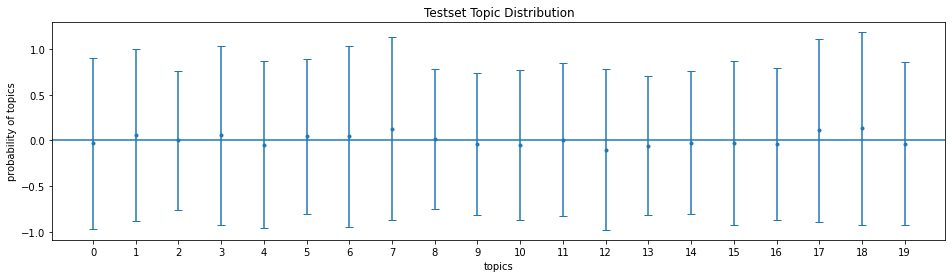

In [ ]:
plt.figure(figsize=(16, 4))
plt.errorbar(range(topics_test.shape[1]), torch.mean(topics_test, dim=0).numpy(), torch.var(topics_test, dim=0).numpy(), linestyle='', marker='.', capsize=4)
plt.axhline(0)
plt.xticks(range(topics_test.shape[1]))
plt.title('Testset Topic Distribution')
plt.ylabel('probability of topics')
plt.xlabel('topics')
plt.show()